# Inventory Analysis for A Liquor Merchandise Entity

The liquor merchandise entity operates as a medium-sized manufacturing company specializing in the sale of diverse liquor brands. Offering an extensive range of products, they manage inventories encompassing raw materials, work-in-progress (WIP), and finished goods. However, the company has encountered challenges in inventory management, such as stockouts, excess inventory, and rising carrying costs. In response to these issues, my goal is to initiate a comprehensive inventory analysis to pinpoint areas for enhancement and optimize their overall inventory management practices.

# Objectives
The inventory management plan involves maintaining detailed records of all transactions, including purchases, production, sales, and adjustments. It includes analyzing historical sales data for demand forecasting, determining optimal order quantities with Economic Order Quantity (EOQ) analysis, calculating reorder points, assessing lead times, analyzing carrying costs, identifying process improvements, and evaluating inventory turnover ratios. The deliverables will encompass comprehensive insights and recommendations based on these analyses to enhance overall inventory management efficiency.



In [1]:
# library imporation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# loading datasets
beg_inv = pd.read_csv('dataset/BegInvFINAL12312016.csv')
end_inv = pd.read_csv('dataset/EndInvFINAL12312016.csv')
invoice_purchases = pd.read_csv('dataset/InvoicePurchases12312016.csv')
sales_1 = pd.read_csv('dataset/SalesFINAL12312016-1.csv')
sales_2 = pd.read_csv('dataset/SalesFINAL12312016-2.csv')
purchases_1 = pd.read_csv('dataset/PurchasesFINAL12312016-1.csv')
purchases_2 = pd.read_csv('dataset/PurchasesFINAL12312016-2.csv')
purchases_3 = pd.read_csv('dataset/PurchasesFINAL12312016-3.csv')
purchases_4 = pd.read_csv('dataset/PurchasesFINAL12312016-4.csv')
purchase_prices = pd.read_csv('dataset/2017PurchasePricesDec.csv')

# concatenating sales and purchases dataset parts
sales = pd.concat([sales_1, sales_2], ignore_index=True)
purchases = pd.concat([purchases_1, purchases_2, purchases_3, purchases_4], ignore_index=True)

In [2]:
# columns
print(f"beg_inv Columns: {beg_inv.columns.tolist()}")
print(f"end_inv Columns:{end_inv.columns.tolist()}")
print(f"invoice_purchases Columns: {invoice_purchases.columns.tolist()}")
print(f"sales Columns: {sales.columns.tolist()}")
print(f"purchases Columns: {purchases.columns.tolist()}")
print(f"purchase_prices Columns: {purchase_prices.columns.tolist()}")

beg_inv Columns: ['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'startDate']
end_inv Columns:['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'endDate']
invoice_purchases Columns: ['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate', 'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval']
sales Columns: ['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity', 'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification', 'ExciseTax', 'VendorNo', 'VendorName']
purchases Columns: ['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber', 'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification']
purchase_prices Columns: ['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification', 'PurchasePrice', 'VendorNumber', 'VendorName']


# Data Wrangling

Before we get to the nitty-gritty part of data analysis, we need to make sure that the dataset we are using are clean, meaning it is accurate, complete, and in a format suitable for analysis. 

First of all, I merged 'Description' and 'Size' to simplify the column and call it 'Product'. This will come in handy later on when we compute for the individual product performance (i.e. top selling, top grossing, etc).
My next step was to remove unnecessary columns and trim the dataframe by slicing to exclude columns that are irrelevant to our analysis.

In [3]:
# creation of product name column
sales['Product'] = sales['Description'] + ' ' + sales['Size']
purchase_prices['Product'] = purchase_prices['Description'] + ' ' + purchase_prices['Size']
purchases['Product'] = purchases['Description'] + ' ' + purchases['Size']
beg_inv['Product'] = beg_inv['Description'] + ' ' + beg_inv['Size']
end_inv['Product'] = end_inv['Description'] + ' ' + end_inv['Size']

# slicing of dataframe to remove irrelevant columns for our analysis
sales_sliced = sales.loc[:, ['Product', 'SalesPrice', 'SalesQuantity', 'Store']]
purchase_prices_sliced = purchase_prices.loc[:, ['Product', 'PurchasePrice']]
purchase_prices_sliced = purchase_prices_sliced.rename(columns={'PurchasePrice': 'Price'})
purchases_sliced = purchases.loc[:, ['Product', 'PurchasePrice']]
purchases_sliced = purchases_sliced.rename(columns={'PurchasePrice': 'Price'})
beg_inv_sliced = beg_inv.loc[:, ['Product', 'Price']]
end_inv_sliced = end_inv.loc[:, ['Product', 'Price']]

On the sales and purchase dataset, I converted the string-type dates into datetime format. This will come in handy later for the computation of lead time:

In [4]:
# data cleaning: converting string dates to datetime
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])
purchases['PODate'] = pd.to_datetime(purchases['PODate'])
purchases['ReceivingDate'] = pd.to_datetime(purchases['ReceivingDate'])

To compute the income, we need information on sales quantity, sales price, and cost. However, the sales dataset does not include the price/cost per sale. I had to create a consolidated price listing by combining the beginning, ending, and purchase_price datasets. After that, I merged the sales table with the purchase price listing to match revenue against expenses. Now that I have a dataframe containing sales and purchase prices called 'final_sales_data,' we are ready for analysis.

In [5]:
# consolidation of listings and dropping of duplicate on the final purchase price listing
price_listing = pd.concat([purchase_prices_sliced, purchases_sliced, beg_inv_sliced, end_inv_sliced], ignore_index=True) # consolidation of listings
price_listing = price_listing.drop_duplicates(subset='Product').reset_index(drop=True) # dropping of duplicates

# merging sales and price_listing dataframe
final_sales_data = pd.merge(sales_sliced, price_listing, on='Product', how='left')

On final_sales_data, I created a new column called "Income", deducting SalesPrice by Price then multiplying by SalesQuantity to get the income per product.

In [6]:
# income computation
final_sales_data["Income"] = final_sales_data["SalesQuantity"] * (final_sales_data["SalesPrice"] - final_sales_data["Price"])

# Top Performers Overview

Now that all products now have their respective income, I can now group the store branches and sum their income. One more thing before doing so, I noticed that the final_sales_data only contains the store ID column, not the branch location/name. By looking at the beg_invt dataset, I can see that it contains the store ID and its respective store location/name. I created a temporary table that contains store id and its corresponding city and merged that with the store_income to replace store id with actual city name of the branch. As you can see below, there are two branches in Doncaster. Both of them have outstanding performance (Top #1 and #3)

Top Performing Store Branches:

In [7]:
# store id
store_id = beg_inv.drop_duplicates(subset='Store').loc[:, ['Store', 'City']]

# Store Income
store_income = final_sales_data.groupby('Store').agg({'Income': 'sum'}).sort_values(by="Income", ascending=False).head(5).reset_index()
store_income = pd.merge(store_income, store_id, on='Store')
store_income = store_income.drop(columns=['Store']).rename(columns={'City': 'Store'})
store_income = store_income.rename(columns={'City': 'Store'})
store_income

,Income,Store
0,502594.90,PITMERDEN
1,466921.63,DONCASTER
2,455387.35,WANBORNE
3,420576.21,DONCASTER
4,418563.90,EANVERNESS


Top Selling Brands:

In [8]:
most_sold_product = sales.groupby('Description')['SalesQuantity'].sum().sort_values(ascending=False).head(5).rename_axis('Product').reset_index()
most_sold_product.index = most_sold_product.index + 1 # sets first index to 1
most_sold_product

,Product,SalesQuantity
1,Smirnoff 80 Proof,43423
2,Capt Morgan Spiced Rum,35866
3,Dr McGillicuddy's Mentholmnt,24188
4,Yukon Jack,24037
5,Jack Daniels No 7 Black,23797


Top Selling Products:

In [9]:
final_sales_data.groupby('Product').agg(SalesQuantity=('SalesQuantity', 'sum')).sort_values(by='SalesQuantity', ascending=False).head(5).rename_axis('Product').reset_index()

,Product,SalesQuantity
0,Smirnoff 80 Proof 50mL,28544
1,Yukon Jack 50mL,23121
2,Capt Morgan Spiced Rum 1.75L,20226
3,Smirnoff Raspberry Vodka 50mL,19200
4,Dr McGillicuddy's Mentholmnt 50mL,18411


Top Profitable Brands:

In [10]:
merged_sales_purchase = pd.merge(sales, purchase_prices, on='Brand', how='left') # merge
merged_sales_purchase['Profit'] = merged_sales_purchase['SalesQuantity'] * (merged_sales_purchase['SalesPrice'] - merged_sales_purchase['PurchasePrice']) # add col
most_profitable_product = merged_sales_purchase.groupby(['Description_x']).agg(Total_Profit=('Profit', 'sum')).sort_values(by='Total_Profit', ascending=False).head(5).rename_axis('Product').reset_index()
most_profitable_product.index = most_profitable_product.index + 1 # sets first index to 1
most_profitable_product

,Product,Total_Profit
1,Capt Morgan Spiced Rum,161057.50
2,Jack Daniels No 7 Black,159726.23
3,Absolut 80 Proof,126319.32
4,Ketel One Vodka,115521.28
5,Grey Goose Vodka,114685.18


Top Profitable Products:

In [11]:
final_sales_data.groupby('Product').agg(TotalProfit=('Income', 'sum')).sort_values(by='TotalProfit', ascending=False).head(5).rename_axis('Product').reset_index()

,Product,TotalProfit
0,Capt Morgan Spiced Rum 1.75L,117756.32
1,Ketel One Vodka 1.75L,97640.30
2,Jack Daniels No 7 Black 1.75L,93098.16
3,Absolut 80 Proof 1.75L,84047.75
4,Tito's Handmade Vodka 1.75L,61745.40


Highest Asset Value:

In [12]:
purchases.groupby(['Product'])['PurchasePrice'].sum().sort_values(ascending=False).head(5).reset_index(name='PurchasePrice')

,Product,PurchasePrice
0,Jack Daniels No 7 Black 1.75L,158591.99
1,Tito's Handmade Vodka 1.75L,137702.22
2,Ketel One Vodka 1.75L,127903.27
3,Crown Royal 1.75L,125396.96
4,Absolut 80 Proof 1.75L,124104.96


Most Expensive Alcohol Products:

In [13]:
purchases.drop_duplicates(subset=['Description', 'PurchasePrice']).nlargest(5, 'PurchasePrice')[['Description', 'PurchasePrice']].reset_index()

,index,Description,PurchasePrice
0,113043,Patron En Lalique Tequila,5681.81
1,185547,Glenmorangie Pride,4264.70
2,966295,Hennessy Richard Cognac,3352.93
3,1452024,Glenfiddich 1978 Rare Collct,2713.17
4,749766,Port Ellen 32 Yr Single Malt,2661.86


Most Spent on a Particular Vendor:

In [14]:
purchases.groupby('VendorName').agg({'Dollars': 'sum'}).sort_values(by='Dollars', ascending=0).reset_index().head(5)

,VendorName,Dollars
0,DIAGEO NORTH AMERICA INC,46452333.24
1,MARTIGNETTI COMPANIES,24924389.85
2,JIM BEAM BRANDS COMPANY,22029427.43
3,PERNOD RICARD USA,21797281.01
4,BACARDI USA INC,16368548.71


Top Performing Vendors in Terms of Order Fulfillment Time

In [15]:
purchases['DaysBetween'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days
purchases.groupby('VendorName').agg({'DaysBetween': 'mean'}).sort_values(by='DaysBetween', ascending=1).reset_index().head()

,VendorName,DaysBetween
0,TRUETT HURST,5.000000
1,LOYAL DOG WINERY,5.117647
2,VINEYARD BRANDS LLC,6.076923
3,MARTIGNETTI COMPANIES,6.697279
4,ALISA CARR BEVERAGES,6.809524


# Safety Stock and Reorder Point Analysis
The code/table below computes for safety stock and reorder point per individual brand and size. Knowing safety stock is crucial to guard against uncertainties in demand and supply, reducing the risk of stockouts. Reorder point is essential for determining when to replenish inventory, ensuring continuous availability and optimal stock levels for efficient operations.

There are different ways to calculate Safety Stock depending on what the entity's available information/data. The most commonly used formula is the managerial accounting variation = (Max Daily Sale * Max Lead Time) − (Avg Daily Sale * Avg Lead Time), however to account for variability in demand/sale during the lead time, I used the Standard Deviation Safety Stock formula = z * sqrt(Avg Lead Time) * σ(Sales)


Another relevant information to extract from this analysis is determining optimal order quantities, calculating reorder points, assessing lead times, establishing safety stock based on statistical analysis, and evaluating inventory turnover ratios.
Safety stock is the extra inventory a company keeps beyond average demand. It acts as a buffer to prevent stockouts during unexpected demand or supply chain fluctuations, ensuring smooth operations and customer satisfaction.
There are various methods for calculating Safety Stock, depending on available information. The widely used managerial accounting formula is (Max Daily Sale * Max Lead Time) − (Avg Daily Sale * Avg Lead Time). However, this formula does not account for outliers, which might lead to inaccurate analysis. To address demand variability during lead time, the Standard Deviation Safety Stock formula is applied: z * sqrt(Avg Lead Time) * σ(Sales), where z represents a confidence level and σ(Sales) is the standard deviation of sales.

But before we delve into the computation part, I need to perform data wrangling/cleaning once again. I grouped the sales data by 'Product' column and aggregated with following metrics: total sales, standards deviation, and max daily sales. For lead time, I calculated the difference between ReceivingDate and PODate for the lead time period, then aggregated with max and mean.

In [16]:
# sales_data
sales_data = sales.groupby(['Product']).agg(
    Total_Sales=('SalesQuantity', 'sum'),
    Standard_Deviation_Sales=('SalesQuantity', 'std'),
    Max_Daily_Sales=('SalesQuantity', 'max')
).reset_index()
sales_data['Avg_Daily_Sales'] = sales_data['Total_Sales'] / (sales['SalesDate'].max() - sales['SalesDate'].min()).days

# lead_times
purchases['Lead_Time'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days
lead_times = purchases.groupby(['Product']).agg(
    Max_Lead_Time=('Lead_Time', 'max'),
    Avg_Lead_Time=('Lead_Time', 'mean'),
).reset_index()

# merging sales_data and lead_times
invt_level_analysis = pd.merge(sales_data, lead_times, on=['Product'], how='left')

Now that I have merged dataset of sales_data and lead_times, I am now able to create a new column called Safety_Stock and Reorder_Point with the following formula below:

In [17]:
# safety stock and reorder point computation
invt_level_analysis['Safety_Stock'] = 1.96 * np.sqrt(invt_level_analysis['Avg_Lead_Time'] * invt_level_analysis['Standard_Deviation_Sales']) # note: z-value with 95% confidence level is 1.96
invt_level_analysis['Reorder_Point'] = (invt_level_analysis['Avg_Daily_Sales'] * invt_level_analysis['Avg_Lead_Time'] + invt_level_analysis['Safety_Stock'])

Upon doing so, I discovered that there are 1222 products that have null values in their Safety_Stock and Reorder_Point columns. This is because there were no purchases of those particular products during the covered period of this dataset, hence no data for their lead time, which is crucial information in determining their safety stock.

In [18]:
(invt_level_analysis['Safety_Stock'].isna() | invt_level_analysis['Reorder_Point'].isna()).sum()

1231

I decided to remove the the NaN values as it is unnecessary to have those rows.

In [26]:
# remove NaN in Standard_Deviation_Sales
invt_level_analysis['Standard_Deviation_Sales'] = invt_level_analysis['Standard_Deviation_Sales'].fillna(0)
invt_level_analysis = invt_level_analysis.dropna(subset=['Reorder_Point'])
invt_level_analysis = invt_level_analysis.dropna(subset=['Safety_Stock'])
invt_level_analysis['Reorder_Point'] = invt_level_analysis['Reorder_Point'].astype(int) # to convert Reorder_Point values to integer
invt_level_analysis['Safety_Stock'] = invt_level_analysis['Safety_Stock'].astype(int)

# Analysis and Recommendation
The output table shows safety stock and reorder point per product. Let's use '10 Span Cab Svgn CC 750mL' as our sample for analysis:
1. The reorder point for '10 Span Chard CC 750mL' is 22 (units). This signifies that the store should initiate a reorder when the stock quantity approaches 22 units. This proactive measure helps prevent stockouts, ensuring a consistent supply of the product to meet customer demand.
2. The safety stock is set at 11 units for '10 Span Chard CC 750mL'. This represents a buffer stock strategically maintained to mitigate the impact of variability in sales quantities. The safety stock acts as a safeguard, providing a cushion against unexpected increases in demand, delays in replenishment, or other unforeseen factors.

In [27]:
invt_level_analysis.loc[:, ['Product', 'Safety_Stock', 'Reorder_Point']]

,Product,Safety_Stock,Reorder_Point
0,(RI) 1 750mL,2,7
1,10 Span Cab Svgn CC 750mL,0,3
2,10 Span Chard CC 750mL,11,22
3,10 Span Pnt Nr CC 750mL,12,17
4,12 Days of Pearls Gift Set 50mL 12 Pk,4,8
...,...,...,...
7643,Zorvino Vyds Peachez 750mL,3,12
7644,Zorvino Vyds Pearz 750mL,3,18
7645,Zorvino Vyds Sangiovese 750mL,5,9
7646,Zum Rsl 750mL,5,18


The table below displays the products with reorder points exceeding the ending inventory level. These items require restocking beyond their reorder points, as they are at a critical level

In [21]:
invt_level_summary = invt_level_analysis.loc[:, ['Product', 'Safety_Stock', 'Reorder_Point']]
end_inv_level = end_inv.loc[:, ['Product', 'onHand']]
on_hand_vs_reorder_point = pd.merge(invt_level_summary, end_inv_level, on=['Product'], how='left')
on_hand_vs_reorder_point[on_hand_vs_reorder_point['onHand'] < on_hand_vs_reorder_point['Reorder_Point']]

,Product,Safety_Stock,Reorder_Point,onHand
1,(RI) 1 750mL,2.841300,7,6.0
2,(RI) 1 750mL,2.841300,7,5.0
3,(RI) 1 750mL,2.841300,7,6.0
4,(RI) 1 750mL,2.841300,7,3.0
5,(RI) 1 750mL,2.841300,7,3.0
...,...,...,...,...
190950,Zum Rsl 750mL,5.643232,18,16.0
190951,Zum Rsl 750mL,5.643232,18,11.0
190952,Zum Rsl 750mL,5.643232,18,16.0
190953,Zum Rsl 750mL,5.643232,18,5.0


By looking at the ending balances, 87% of the total inventory do not follow the recommended minimum stock. This indicates that the company's inventory level is far from optimal.

In [22]:
(on_hand_vs_reorder_point['Reorder_Point'] > on_hand_vs_reorder_point['onHand']).sum() / on_hand_vs_reorder_point.shape[0]

0.8761239441340197

# Data Visualization
Another way to perform analysis is through visualization of data.

The diagram below shows that the sales quantities exhibit a cyclical pattern, suggesting potential trend during weekend as it is common for people to consume alcohol on fridays & weekends. The spike in alcohol/liquor purchases at the end of January may be attributed to holiday celebrations and gatherings. The drop in sales during February could be influenced by reduced social events, financial considerations, health-related resolutions, or other factors contributing to a decline in demand. This also implies the need to consider staffing levels at your shop over the weekends, given that the data indicates a recurring peak in sales during this time.

<Axes: title={'center': 'Daily Quantity Sale for the month of January and February 2016'}, xlabel='SalesDate'>

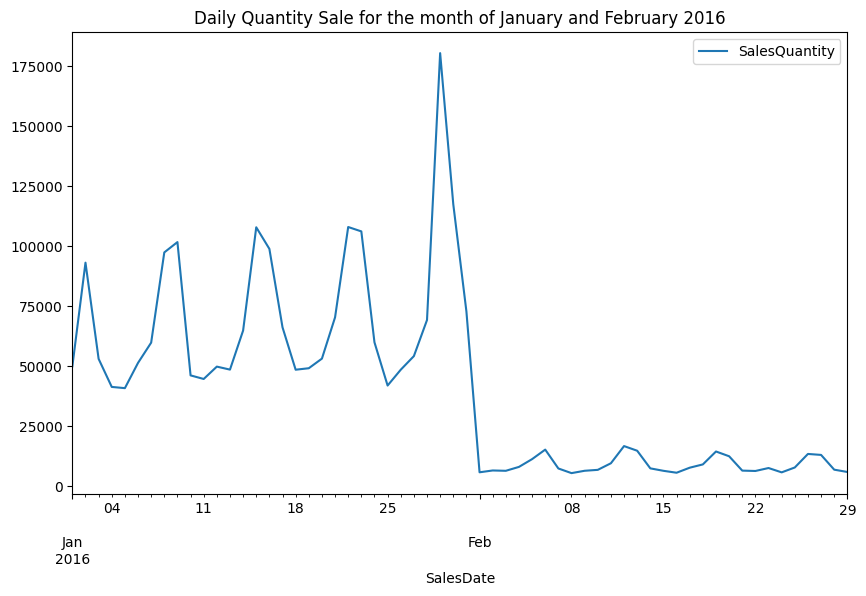

In [23]:
daily_quantity_sale = sales.groupby('SalesDate').agg({'SalesQuantity': 'sum'})
daily_quantity_sale.plot(figsize=(10, 6), title='Daily Quantity Sale for the month of January and February 2016')

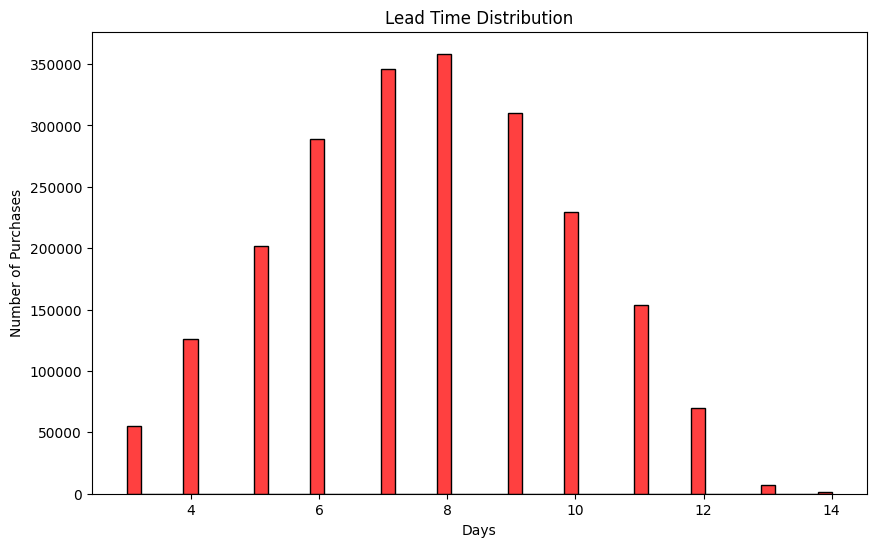

In [24]:
# Creating the histogram for lead time distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data=purchases, x='Lead_Time', bins=50, color='red')
plt.title('Lead Time Distribution')
plt.xlabel('Days')
plt.ylabel('Number of Purchases')
plt.show()

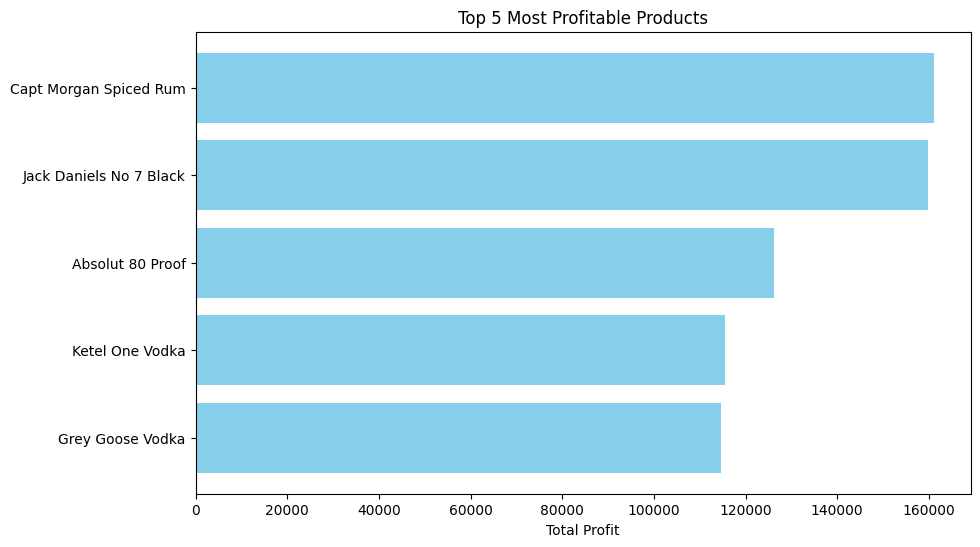

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(most_profitable_product['Product'], most_profitable_product['Total_Profit'], color='skyblue')
plt.xlabel('Total Profit')
plt.title('Top 5 Most Profitable Products')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest profit at the top
plt.show()

# Conclusion

Overall, the company's inventory management level is suboptimal, with a significant amount of inventory falling below its recommended stock levels. Best practices dictate that stock levels should consistently remain above the reorder point to mitigate the risk of stockout costs. The amount of purchase per order per product is currently uncomputable due to the absence of crucial variables required to measure the economic order quantity, namely holding cost and order cost. In the meantime, as the company lacks this information, it is advisable to avoid letting inventory levels fall below the reorder point.

Top Products:<br>
* Top Sold Brand: Units sold of Smirnoff is 43K<br>
* Top Sold Product: Units sold of Smirnoff 80 Proof (50mL) is 29K<br>
* Top Profitable Brand: Profit of Capt Morgan Spiced Rum is $161K<br>
* Top Profitable Product: Capt Morgan Spiced Rum 1.75L is $118K<br>

Vendor Performances:
* Fastest delivery: Vendor Truett Hurst boasts the quickest delivery, with an average lead time of 5 days.<br>
* Primary vendor: Total spent on Vendor Deageo North America Inc is whopping $46.4M<br>

Other Notable Findings:
* Most Expensive Alcohol on hand:  Patron En Lalique Tequila with a price of $5,682 per unit.<br>
* Sales reached their highest point on January 30th, but experienced a decline in February.<br>
* Sale trends during weekend as it is common for people to consume alcohol on Fridays & weekends.<br>
* Top performing branches are in DonCaster with income of whopping $887K<br>
* Average lead time is 8 days.<br>
* Smirnoff 80 Proof 50mL requires the most stock with 3,705 units of reorder point. Which is expected because this is the highest sale velocity.<br>